MONOMER GUI DETECTOR


In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import json
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#DATA_PATH = r'D:\amityu\backoffice_data\\'

#movie = 'Control'
#movie ='140721'
#movie ='150721'
#movie ='100621'
#movie = '130721_CCA60_RAW'
#movie ='280523 AM100 568_2'
#movie ='280523 AM100 568_3'
#movie ='cca120'
#movie = 'control_1_050721'
#movie = 'control_2_230523'
#movie = 'cca120_am200'
#movie = 'cca40'
#movie = 'cca300'
#movie = 'cca60_dist'
#movie = '160624c10'
movie = '140824'
#movie = '140824long'
#movie = '270524c8'
MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
gel_file_name = MOVIE_PATH + 'tmp/gel_corrected.npy'
#import gaussian from opencv
#from cv2 import GaussianBlur as gaussian

## for visualization contrast purpose global min and global max should be determined. to save time you calculate it once 

In [2]:
first = False
gel = np.load(gel_file_name, mmap_mode='r')
if first:
    global_min = np.nanmin(gel)
    global_max = np.nanpercentile(gel, 99.7)
else:
    global_max =2.92
    global_min = 0.77

In [4]:
global_max, global_min

(2.9275288169384055, 0.7728902)

In [3]:
save_data_file_name = MOVIE_PATH + 'np/monomer_rect.csv'

In [4]:
# if save_data_file_name doestn't exist: initialize dataframe for first time. 
if ~os.path.isfile(save_data_file_name):
    df = pd.DataFrame()
    df['frame'] = np.arange(len(gel))  # frame index
    df['Z'] = [0]* len(gel)   #z lower box coordinate
    df['Y'] = [50]* len(gel)   #y box coordinate
    df['X'] = [50]* len(gel)
    df['r_size'] = [18]* len(gel)  # size of the picking rectangle
    df['y_gap'] = [20]* len(gel)  # mip width
    df['mean'] = [0.0]* len(gel) #mean intensity
    df['std'] = [0.0]* len(gel)  # standard deviation intensity
    df['gap_from_surface'] = [10]* len(gel)  #how many pixels to ignore in the z coordinates. rectangle is put on the surface, and this is the amount of pixels to ignore
    #save dataframes
    df.to_csv(save_data_file_name, index=False)


In [11]:
'''params_dict = {'save_data_file_name' :save_data_file_name,
             'global_min': float(global_min),
             'global_max': float(global_max),
             'movie': movie,
             'MOVIE_PATH':MOVIE_PATH,
             'gel_file_name': gel_file_name}

with open("seg_parameters.json", "w") as json_file:
    json.dump(params_dict, json_file, indent=4)'''

In [6]:
# Dependencies
import cv2
import numpy as np
import pandas as pdq

# Global constants
IMAGE_HEIGHT = 500
FONT_SCALE = 0.7
FONT = cv2.FONT_HERSHEY_SIMPLEX
COLOR = (255, 255, 255)  # white color
THICKNESS = 2  # line thickness
POSITIONS = {"position": (10, 50), "exit": (10, 100), "position2": (10, 150), "position3": (10, 200)}


def load_data(file_path):
    """
    Load data from a csv file and set the index to 'frame'.

    :param file_path: The path of the csv file to load.
    :return: The loaded data as a pandas DataFrame with the index set to 'frame'.
    """
    df = pd.read_csv(file_path)
    df.set_index('frame', inplace=True)
    return df





def draw_rectangle(event, x, z, flags, param ):
    """
    :param event: The event triggered in the GUI
    :param x: The x-coordinate of the rectangle
    :param z: The z-coordinate of the rectangle
    :param flags: The flags associated with the event
    :param param: A dictionary containing additional parameters (dataframe and frame index
    :return: None

    The method is used as a callback to draw a rectangle in the GUI. It updates the dataframe with the mean and standard deviation values based on the selected rectangle.

    """
    df=param['df']
    frame_index=param['frame_index']
    # Callback logic here...
    mean = df.loc[frame_index, 'mean']
    std = df.loc[frame_index, 'std']

    r_size= df.loc[frame_index, 'r_size']
    gap_from_surface = df.loc[frame_index, 'gap_from_surface']
    y_gap = df.loc[frame_index, 'y_gap']
    y = df.loc[frame_index, 'Y']

    if event == cv2.EVENT_LBUTTONDOWN:

        i_data = gel[frame_index, z + gap_from_surface:z + r_size, y:y + y_gap, x:x + r_size]
        i_data = i_data[~np.isnan(i_data)]
        mean = np.nanmean(i_data)
        std = np.nanstd(i_data)
        if np.isnan(mean):
            mean = 0
        if np.isnan(std):
            std = 0
        df.loc[frame_index] = {'Z':z,'Y':y, 'X':x, 'r_size':r_size, 'y_gap':y_gap, 'mean':mean, 'std':std, 'gap_from_surface':gap_from_surface}

    elif event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:  # scroll up
            if y + y_gap < gel.shape[2]:
                y+= y_gap  # cycle through images
        
        else:  # scroll down
            y-= y_gap  # cycle through images
            if y< 0:
                y = 0
        df.loc[frame_index, 'Y'] = y


def build_image(df, frame_index):
    """
    :param df: DataFrame containing selection data 
    :param frame_index: Index of the frame to build the image for
    :return: Image representation of the frame with additional data overlay

    """
    # Formatting logic here...
    y_gap = df.loc[frame_index, 'y_gap']
    y = df.loc[frame_index, 'Y']
    r_size= df.loc[frame_index, 'r_size']
    x =  df.loc[frame_index, 'X']
    z =  df.loc[frame_index, 'Z']
    gap_from_surface = df.loc[frame_index, 'gap_from_surface']
    mean = df.loc[frame_index, 'mean']
    std = df.loc[frame_index, 'std']

    img = np.max(gel[frame_index, :, y:y + y_gap, :], axis=1)
    img[np.isnan(img)] = 0
    img = ((img - global_min) / (global_max - global_min) * 255).astype(np.uint8)
    #img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.rectangle(img, pt1=(x, z), pt2=(x+r_size, z+r_size), color= COLOR, thickness=2)

    gel_image = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    data_img = np.zeros((600,img.shape[1]), dtype=np.uint8)
    data_string = f'Time: {frame_index}, X: { df.loc[frame_index, "X"]}, Y: {y}, Z: {df.loc[frame_index, "Z"]} , Y MIP size: {y_gap}'
    data_string2 = f' , r_size: {r_size}, gap_from_surface: {gap_from_surface}'
    data_string3 = f' , mean: {mean:.2f}, std: {std:.2f}'
    exit_string = 's  to save, q to quit, 2/8 to change time'
    cv2.putText(data_img, data_string, POSITIONS["position"], FONT, FONT_SCALE, COLOR, THICKNESS)
    cv2.putText(data_img, exit_string, POSITIONS["exit"], FONT, FONT_SCALE, COLOR, THICKNESS)
    cv2.putText(data_img, data_string2, POSITIONS["position2"], FONT, FONT_SCALE, COLOR, THICKNESS)
    cv2.putText(data_img, data_string3, POSITIONS["position3"], FONT, FONT_SCALE, COLOR, THICKNESS)
    data_img = cv2.applyColorMap(data_img, cv2.COLORMAP_JET)

    return cv2.vconcat([gel_image, data_img])

def main():
    """
    Main method 

    :return: None
    """
    # DataFrame for data
    df = load_data(save_data_file_name)
    frame_index = 0
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    
    
    while True:
        cv2.setMouseCallback('image', draw_rectangle, param={'df':df, 'frame_index':frame_index})

        # Display the image
        colored_image = build_image(df,frame_index)
        cv2.imshow('image', colored_image)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            cv2.imwrite(DATA_PATH + 'monomer_app.jpg', colored_image)
            break

        elif key == ord('2'):
            frame_index += 1
            if frame_index >= len(gel):
                frame_index = 0

        elif key == ord('8'):
            frame_index -= 1
            if frame_index < 0:
                frame_index = len(imgs) - 1

        elif key == ord('s'):
            df.to_csv(save_data_file_name, index=True)
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()


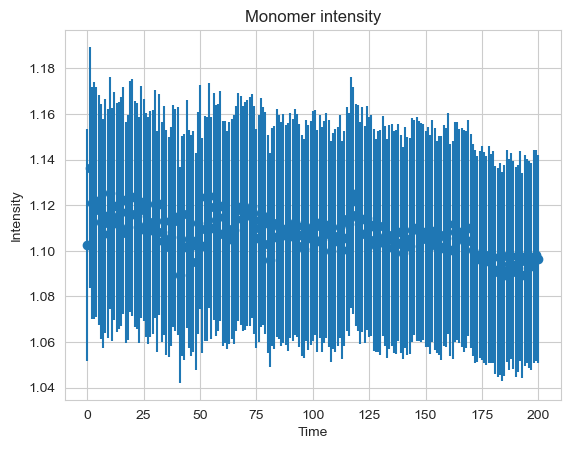

In [18]:

df = pd.read_csv(save_data_file_name, index_col=0)
plt.errorbar(np.arange(len(df)), df['mean'], yerr=df['std'], fmt='o')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Monomer intensity')
plt.show()      


In [19]:
del gel